In [1]:
using ImageView
using Distributed

# Auxiliary functions, GRASP and processes initialization

In [3]:
nprocs()

1

In [4]:
addprocs(11)

11-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12

In [5]:
@everywhere using FileIO
@everywhere using Images

In [6]:
@everywhere function count_colors(img)
    _, rows, columns = size(img)
    rows_range, columns_range = 1:rows, 1:columns
    colors_count = Dict()
    colors_set = Set()
    for i in rows_range
        for j in columns_range
            color = img[:, i, j]
            if color in colors_set
                colors_count[color] += 1
            else
                push!(colors_set, color)
                colors_count[color] = 1
            end
        end
    end

    return colors_count, colors_set
end

@everywhere function construct_pizza(colors_count)
    pairs = [[key, value] for (key, value) in colors_count]
    pairs = reduce(vcat,transpose.(pairs))
    
    colors_number = length(colors_count)
    total = sum(pairs[:, 2])
    freqs = pairs[:, 2] ./ total

    probs = [freqs[1]]
    for i in 2:colors_number
        push!(probs, probs[end] + freqs[i])
    end

    return pairs[:, 1], probs
end

@everywhere function select_from_pizza(pizza)
    r = rand()
    for (i, p) in enumerate(pizza)
        if r <= p
            return i
        end
    end

    return length(pizza)
end

In [7]:
@everywhere function dist_img(img, original_img)
    return norm(original_img .- img)
end

@everywhere function create_palette(possible_colors, pizza, palette_size=16)
    palette = []
    selected_colors_idx = Set()

    #define the palette
    for i in 1:palette_size
        color_idx = select_from_pizza(pizza)
        while color_idx in selected_colors_idx
            color_idx = select_from_pizza(pizza)
        end
        push!(palette, possible_colors[color_idx])
        push!(selected_colors_idx, color_idx)
    end

    return palette
end

@everywhere function color_img(img_matrix, palette)
    _, rows, columns = size(img_matrix)
    rows_range = 1:rows
    columns_range = 1:columns
    
    #initialize a new matrix and an index matrix
    #to fasten the computations
    new_img = zeros(size(img_matrix))
    index_img = ones(Int64, size(img_matrix, 2), size(img_matrix, 3))
    
    #recolor each pixel with the nearest color
    for i in rows_range
        for j in columns_range
            #get the color with minimum distance
            min_dist = Inf
            idx = 1
            for (k, color) in enumerate(palette)
                dist = norm(img_matrix[:, i, j] - color)
                if dist < min_dist
                    min_dist = dist
                    idx = k
                end
            end
            new_img[:, i, j] = palette[idx]
            index_img[i, j] = idx
        end
    end
    return new_img, index_img
end

@everywhere function quantize(img_matrix, possible_colors, pizza, palette_size)
    palette = create_palette(possible_colors, pizza, palette_size)
    new_img, index_img = color_img(img_matrix, palette)
    return new_img, index_img, palette
end

@everywhere function change_palette(f, possible_colors, pizza, f_val,
                        img_matrix, palette_img,
                        index_img, palette,
                        color_changes, number_changes=10)

    #define some important variables
    _, rows, columns = size(img_matrix)
    palette_size = size(palette, 1)
    
    rows_range = 1:rows
    columns_range = 1:columns
    palette_range = 1:palette_size

    #create the matrix will be colored
    #and the matrix with the best image
    best_img = deepcopy(palette_img)

    #try different palettes
    for n in 1:number_changes

        #create a new palette
        selected_colors = Set(deepcopy(palette))
        selected_idx = Set()
        new_palette = deepcopy(palette)
        
        for c in 1:color_changes
            color_idx = rand(palette_range)
            while color_idx in selected_idx
                color_idx = rand(palette_range)
            end
            
            color = possible_colors[select_from_pizza(pizza)]
            while color in selected_colors
                color = possible_colors[select_from_pizza(pizza)]
            end
            new_palette[color_idx] = color
            push!(selected_idx, color_idx)
            push!(selected_colors, color)
        end

        #recolor the image with the new palette
        for i in rows_range
            for j in columns_range
                if index_img[i, j] in selected_colors
                    palette_img[:, i, j] = palette[index_img[i, j]]
                end
            end
        end

        #compute the distance and update the best image
        distance = f(palette_img)
        if distance < f_val
            f_val = distance
            best_img = deepcopy(palette_img)
        end
    end
    return best_img, f_val
end

In [8]:
@everywhere function grasp_iter(args)
    f=args[1]
    random_greedy=args[2]
    local_search=args[3]
    iter=args[4]
    verbose=args[5]
    
    palette_img, index_img, palette = random_greedy()

    f_x = f(palette_img)
    new_img, f_val = local_search(f_x, palette_img, index_img, palette)
    return new_img, f_val
end

function parallel_grasp_image_imgs(f, random_greedy, local_search, max_iter=100, verbose=0)
    iter = 1
    global χ = Inf
    global f_χ = Inf
    
    imgs = []
    vals = []
    procs_number = nprocs()
    args_gen = x -> [f, random_greedy, local_search, x, verbose]
    while iter <= max_iter
        args = []
        for i in 0:procs_number-1
            push!(args, args_gen(iter+i))
        end
        answers = pmap(grasp_iter, args)

        for (i, ans) in enumerate(answers)
            new_img, f_val = ans
            push!(vals, f_val)
            if verbose == 1
                println("iteration $(iter+i-1) starting! f(χ) = $f_χ")
            end
            if f_val < f_χ
                χ = new_img
                f_χ = f_val
                push!(imgs, (χ, iter+i-1))
            end
        end
        iter+=procs_number
    end
    return imgs, vals
end

parallel_grasp_image_imgs (generic function with 3 methods)

In [9]:
function display_images(imgs)
    for img in imgs
        display(colorview(RGB, img[1]))
    end
end

display_images (generic function with 1 method)

# Naruto

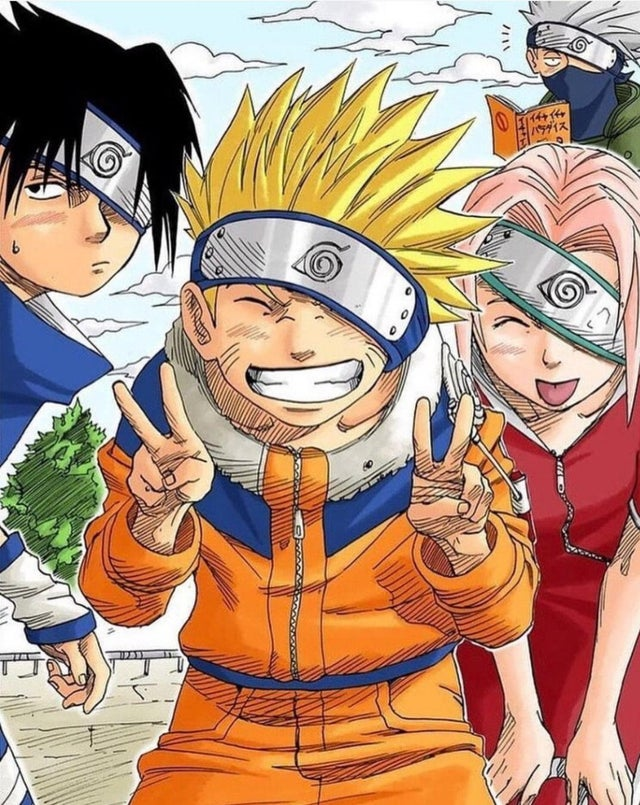

In [11]:
@everywhere img = FileIO.load("./time7.jpg")
display(img)
@everywhere img_matrix = channelview(img);

In [12]:
colors_count, _ = count_colors(img_matrix)
possible_colors, pizza = construct_pizza(colors_count)

palette_size = 64
number_changes = 20
color_changes = 16

@everywhere f = x -> dist_img(x, img_matrix)
@everywhere ls = (f_val, palette_img, index_img, palette) -> change_palette(f, possible_colors, pizza, f_val,
                                                img_matrix, palette_img,
                                                index_img, palette,
                                                color_changes, number_changes)
max_iter = 12 * 2
@everywhere rg = () -> quantize(img_matrix, possible_colors', pizza, palette_size)

iteration 1 starting! f(χ) = Inf
iteration 2 starting! f(χ) = 256.2554860694241
iteration 3 starting! f(χ) = 142.96239671421867
iteration 4 starting! f(χ) = 142.96239671421867
iteration 5 starting! f(χ) = 142.96239671421867
iteration 6 starting! f(χ) = 142.96239671421867
iteration 7 starting! f(χ) = 142.96239671421867
iteration 8 starting! f(χ) = 142.96239671421867
iteration 9 starting! f(χ) = 142.96239671421867
iteration 10 starting! f(χ) = 142.96239671421867
iteration 11 starting! f(χ) = 142.96239671421867
iteration 12 starting! f(χ) = 142.96239671421867
iteration 13 starting! f(χ) = 142.96239671421867
iteration 14 starting! f(χ) = 139.68717557587206
iteration 15 starting! f(χ) = 139.68717557587206
iteration 16 starting! f(χ) = 139.68717557587206
iteration 17 starting! f(χ) = 139.68717557587206
iteration 18 starting! f(χ) = 139.68717557587206
iteration 19 starting! f(χ) = 139.68717557587206
iteration 20 starting! f(χ) = 139.68717557587206
iteration 21 starting! f(χ) = 139.68717557587

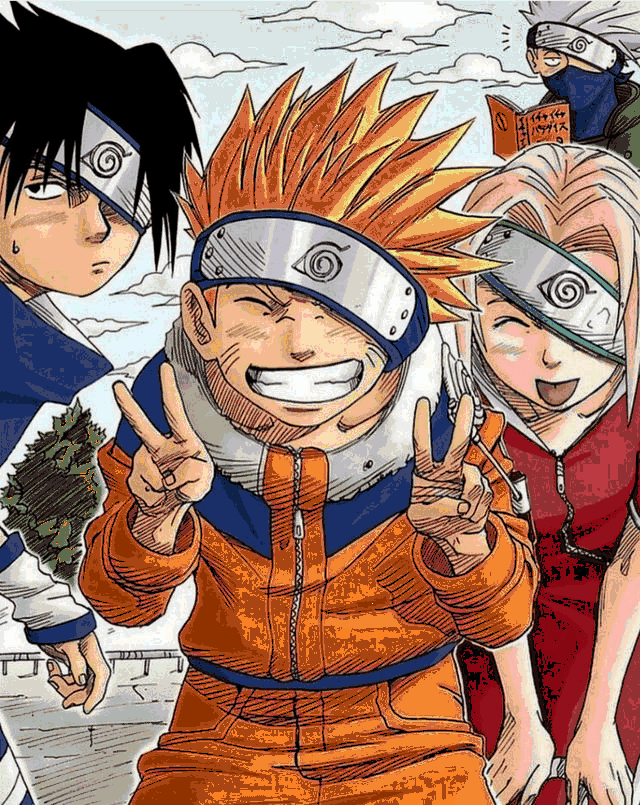

In [13]:
@time begin
    final_imgs, vals = parallel_grasp_image_imgs(f, rg, ls, max_iter, 1);
end
display_images([final_imgs[end]])

# Pokémon

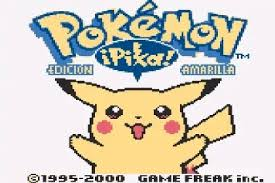

In [15]:
@everywhere img = FileIO.load("./pokemon_yellow.jpg")
display(img)
@everywhere img_matrix = channelview(img);

In [16]:
colors_count, _ = count_colors(img_matrix)
possible_colors, pizza = construct_pizza(colors_count)

palette_size = 56
number_changes = 20
color_changes = 10

@everywhere f = x -> dist_img(x, img_matrix)
@everywhere ls = (f_val, palette_img, index_img, palette) -> change_palette(f, possible_colors, pizza, f_val,
                                                img_matrix, palette_img,
                                                index_img, palette,
                                                color_changes, number_changes)
max_iter = 12 * 5
@everywhere rg = () -> quantize(img_matrix, possible_colors', pizza, palette_size)

iteration 1 starting! f(χ) = Inf
iteration 2 starting! f(χ) = 102.81056804983504
iteration 3 starting! f(χ) = 93.0411977722275
iteration 4 starting! f(χ) = 44.75208981135325
iteration 5 starting! f(χ) = 44.75208981135325
iteration 6 starting! f(χ) = 44.75208981135325
iteration 7 starting! f(χ) = 44.75208981135325
iteration 8 starting! f(χ) = 44.75208981135325
iteration 9 starting! f(χ) = 44.75208981135325
iteration 10 starting! f(χ) = 44.75208981135325
iteration 11 starting! f(χ) = 44.75208981135325
iteration 12 starting! f(χ) = 44.75208981135325
iteration 13 starting! f(χ) = 44.75208981135325
iteration 14 starting! f(χ) = 44.75208981135325
iteration 15 starting! f(χ) = 44.75208981135325
iteration 16 starting! f(χ) = 44.75208981135325
iteration 17 starting! f(χ) = 44.75208981135325
iteration 18 starting! f(χ) = 44.75208981135325
iteration 19 starting! f(χ) = 44.75208981135325
iteration 20 starting! f(χ) = 44.75208981135325
iteration 21 starting! f(χ) = 44.75208981135325
iteration 22 st

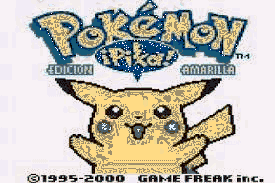

In [17]:
@time begin
    final_imgs, vals = parallel_grasp_image_imgs(f, rg, ls, max_iter, 1);
end
display_images([final_imgs[end]])

# Cats

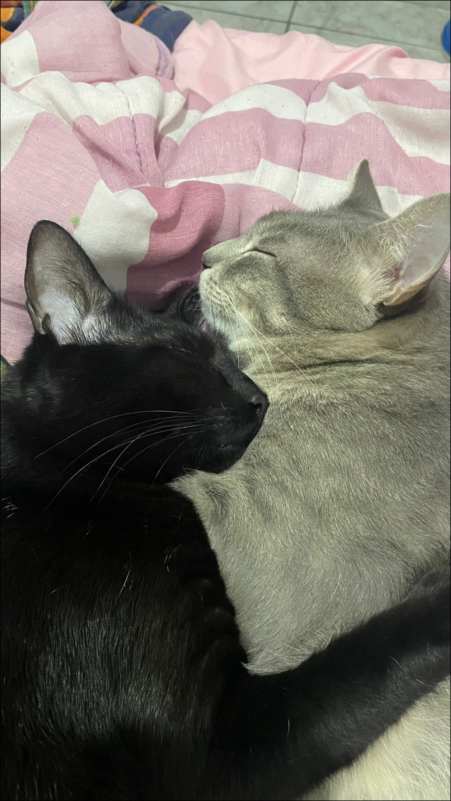

In [19]:
@everywhere img = FileIO.load("./gatos1.jpeg")
display(img)
@everywhere img_matrix = channelview(img);

In [20]:
colors_count, _ = count_colors(img_matrix)
possible_colors, pizza = construct_pizza(colors_count)

palette_size = 64
number_changes = 20
color_changes = 16

@everywhere f = x -> dist_img(x, img_matrix)
@everywhere ls = (f_val, palette_img, index_img, palette) -> change_palette(f, possible_colors, pizza, f_val,
                                                img_matrix, palette_img,
                                                index_img, palette,
                                                color_changes, number_changes)
max_iter = 12 * 2
@everywhere rg = () -> quantize(img_matrix, possible_colors', pizza, palette_size)

In [ ]:
@time begin
    final_imgs, vals = parallel_grasp_image_imgs(f, rg, ls, max_iter, 1);
end
display_images([final_imgs[end]])

iteration 1 starting! f(χ) = Inf
iteration 2 starting! f(χ) = 159.42967745326487
iteration 3 starting! f(χ) = 159.42967745326487
iteration 4 starting! f(χ) = 159.42967745326487
iteration 5 starting! f(χ) = 104.81394445738869
iteration 6 starting! f(χ) = 92.65595741047409
iteration 7 starting! f(χ) = 92.65595741047409
iteration 8 starting! f(χ) = 92.65595741047409
iteration 9 starting! f(χ) = 92.65595741047409
iteration 10 starting! f(χ) = 92.65595741047409
iteration 11 starting! f(χ) = 92.65595741047409
iteration 12 starting! f(χ) = 92.65595741047409
